## Kütüphanelerin yüklenmesi

In [ ]:
import tensorflow as tf #derin öğrenme ve makine öğrenme kütüphanesi
from tensorflow.keras.layers import Dense, Dropout, Input #derin öğrenme için katmanlar
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop #optimizasyon fonksiyonu
import tensorflow.keras.backend as K #Keras arka uç API'si.

In [55]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.

In [56]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

## Verisetinin yüklenmesi

In [57]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


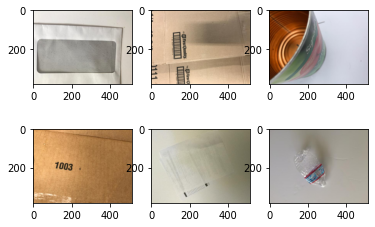

In [58]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Veri setinin modelin girişine hazırlanması ve bölünmesi

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,#Ölçeklendirme, verilen değerle çarpılır.
    shear_range=0.1,#Kesme açısı
    zoom_range=0.1,#Rastgele yaklaştırma
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,#Girilen değeri rastgele yatay çevirme.
    vertical_flip=True,#Girilen değeri rastgele dikey çevirme.
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

test_datagen = ImageDataGenerator(
    rescale=1./255,#ölçeklendirme
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),#Fotoğrafın kaça kaç olacağı
    class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
    subset='training',#Alt küme ayarlama validation/training
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),#Fotoğrafın kaça kaç olacağı
    # batch_size=50,#Veri yığınlarının boyutu.
    class_mode='categorical',
    subset='validation',#Alt küme ayarlama validation/training
    seed=0
)
#Etiketlerin gösterimi
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## Inception mimarisinin yüklenmesi

In [60]:
from keras.applications.inception_v3 import InceptionV3 #Applications içerisinde hazır mimariler bulunmaktadır. 
#Burada Inception mimarisini çekilmiştir.

#Giriş görüntüsünün boyutu(300x300) ayarlandı ve daha önceden indirilen ağırlıklar giriş modeline yüklendi.
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
base_model.load_weights(r'C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\inceptionv3\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False

## Yeni model oluşturma

In [61]:
from keras.models import Sequential#Model oluşturmayı sağlar.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
#Konvolüsyon,Flatten(Düzleştirme),Havuzlama(MAX),Dropout ve Normal katmanların kullanımını sağlar.

model = Sequential([#Model oluşturma
    base_model,#Giriş modeli (Functional)
    GlobalAveragePooling2D(),#Havuzlama Katmanı
    Dropout(0.15),
    Dense(1024, activation='relu'),#Tam bağlı katman
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, use_bias=False, activation='linear', name='svm')
    #Dense(6, activation='softmax')#Çıkış katmanı
])

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)              

## Modeli Derleme ve optimizasyon çalışmaları

In [63]:
#SVM için hazırlanan kayıp fonksiyonu
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [64]:
metrics = ['accuracy']
optimizer = tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5)
#optimizer = tf.train.AdamOptimizer(1.e-3)
model.compile(optimizer=optimizer, loss=svm_loss(model.get_layer('svm')), metrics=metrics)

In [68]:
batch_size = 64 #64
epochs = 200 #İterasyon sayısı
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

## Early Stopping ve Model Checkpoint

In [69]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_inception_{epoch:02d}-{val_accuracy:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## Modelin eğitilmesi

In [70]:
history = model.fit_generator(
    generator=train_generator, #Eğitim verisi
    epochs=epochs, #iterasyon sayısı
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,#Test verisi
    validation_steps=validation_steps,
    callbacks=callbacks_list#Early stopping ve model checkpoint değerleri
)

Epoch 1/200
35/35 [==============================] - 29s 656ms/step - loss: 7.9663 - accuracy: 0.2658 - val_loss: 6.2514 - val_accuracy: 0.4375

Epoch 00001: val_accuracy improved from -inf to 0.43750, saving model to model_inception_01-0.44.h5
Epoch 2/200
35/35 [==============================] - 23s 641ms/step - loss: 6.2584 - accuracy: 0.5361 - val_loss: 6.1757 - val_accuracy: 0.6250

Epoch 00002: val_accuracy improved from 0.43750 to 0.62500, saving model to model_inception_02-0.62.h5
Epoch 3/200
35/35 [==============================] - 22s 618ms/step - loss: 6.1584 - accuracy: 0.6766 - val_loss: 6.1177 - val_accuracy: 0.7188

Epoch 00003: val_accuracy improved from 0.62500 to 0.71875, saving model to model_inception_03-0.72.h5
Epoch 4/200
35/35 [==============================] - 23s 643ms/step - loss: 6.0900 - accuracy: 0.7830 - val_loss: 6.0877 - val_accuracy: 0.7292

Epoch 00004: val_accuracy improved from 0.71875 to 0.72917, saving model to model_inception_04-0.73.h5
Epoch 5/200

35/35 [==============================] - 64s 2s/step - loss: 5.9807 - accuracy: 0.8934 - val_loss: 6.0211 - val_accuracy: 0.8854

Epoch 00040: val_accuracy did not improve from 0.91667
Epoch 41/200
35/35 [==============================] - 63s 2s/step - loss: 5.9871 - accuracy: 0.8920 - val_loss: 6.0005 - val_accuracy: 0.8750

Epoch 00041: val_accuracy did not improve from 0.91667
Epoch 42/200
35/35 [==============================] - 65s 2s/step - loss: 5.9773 - accuracy: 0.9062 - val_loss: 6.0598 - val_accuracy: 0.8438

Epoch 00042: val_accuracy did not improve from 0.91667
Epoch 43/200
35/35 [==============================] - 65s 2s/step - loss: 5.9675 - accuracy: 0.9110 - val_loss: 6.0246 - val_accuracy: 0.8542

Epoch 00043: val_accuracy did not improve from 0.91667
Epoch 44/200
35/35 [==============================] - 69s 2s/step - loss: 5.9815 - accuracy: 0.9035 - val_loss: 6.0239 - val_accuracy: 0.8750

Epoch 00044: val_accuracy did not improve from 0.91667
Epoch 45/200
35/35 [===

## Sonuç skoru

In [71]:
score = model.evaluate(validation_generator,batch_size=32)#Modeli test verisi ile dener.
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))#Sonucu yüzdeye uyarlar.

8/8 [==============================] - 16s 2s/step - loss: 6.0742 - accuracy: 0.8645
Score Accuracy : 86.45%


## Eğitim sürecinin görselleştirilmesi

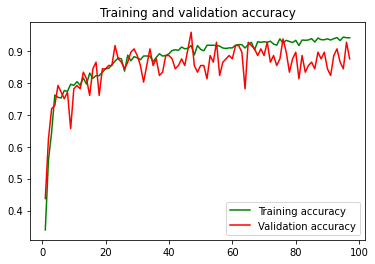

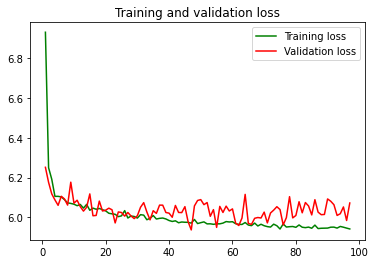

In [72]:
#Eğitim sürecinin görselleştirilmesi

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()